<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создадим-признаки" data-toc-modified-id="Создадим-признаки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создадим признаки</a></span></li><li><span><a href="#Деление-данных-на-тренировочные-и-тестовые" data-toc-modified-id="Деление-данных-на-тренировочные-и-тестовые-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Деление данных на тренировочные и тестовые</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import lightgbm as lgb
import numpy as np
import xgboost as xgb
import warnings
#import statsmodels.api as sm
#import ml_metrics as metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pandas.plotting import autocorrelation_plot

from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

#from pmdarima import auto_arima

from catboost import CatBoostRegressor, Pool

from lightgbm import LGBMRegressor

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# чтение данных, создание колонки в качестве названий индексов через index_col,
# приведение в формат Datetime через parse_dates

data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
display(data.head())
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB

None


In [5]:
# Сортировка индексов в порядке возрастания
data.sort_index(inplace=True)

In [6]:
# проверка на соблюдение порядка
print(data.index.is_monotonic)
print(data.info())

True

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB

None


In [7]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00

2018-08-31 23:50:00


In [8]:
print(data['num_orders'].isna().sum())
print(data.index.isna().sum())

0

0


In [9]:
print(data.isna().sum())

num_orders    0

dtype: int64


### Вывод

* Перевели колонку со временем в названия индексов
* Рассортировали индексы в порядке возрастания
* Проверили на пропуски


Данные подготовлены к анализу.

## Анализ

Т.к. наше задание провести прогноз по пиковым часам, поэтому будем вести анализ по суткам.

<AxesSubplot:xlabel='datetime'>

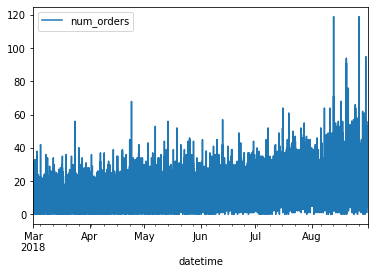

In [10]:
data.plot()

In [11]:
# Ресемлирование на 1 час
data = data.resample('1h').sum()
data['rolling_mean'] = data['num_orders'].rolling(17).mean()
data['std'] = data['num_orders'].rolling(17).std()

### Тренды и сезонность

In [12]:
data.isna().sum()

num_orders       0
rolling_mean    16
std             16
dtype: int64

In [13]:
# Разбитие на части временного ряда

decomposed = seasonal_decompose(data.drop(['std', 'rolling_mean'], axis=1))

Text(0.5, 1.0, 'Trend for six months')

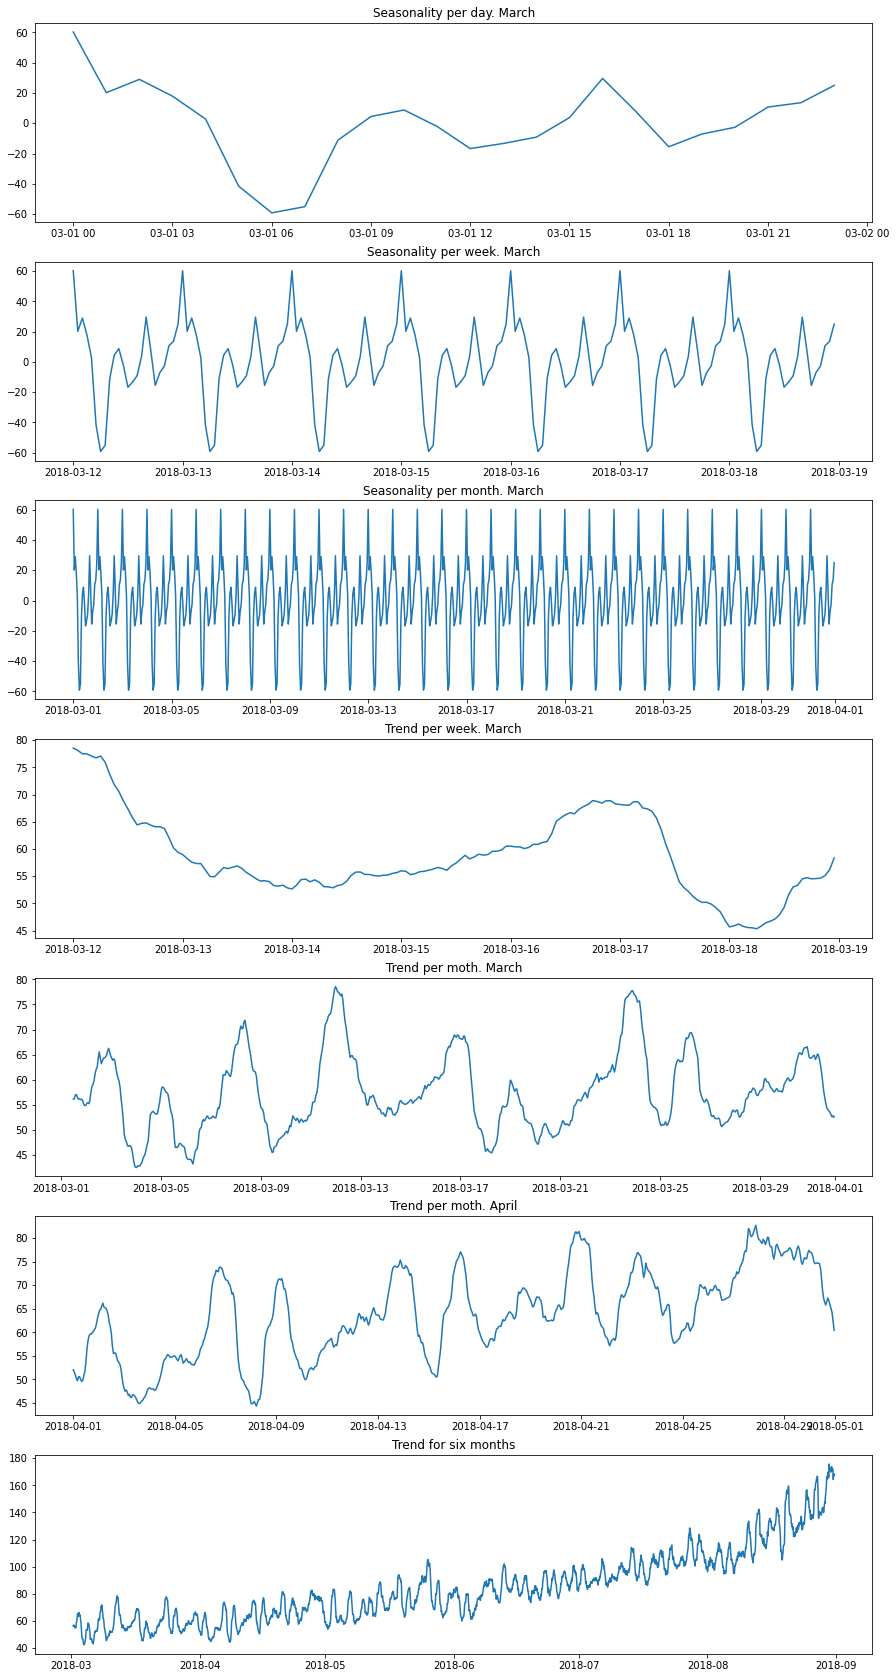

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=7, figsize=(15, 30))

# График сезонности за сутки
ax[0].plot(decomposed.seasonal['2018-03-1':'2018-03-1'])
ax[0].set_title('Seasonality per day. March')

# График сезонности за неделю
ax[1].plot(decomposed.seasonal['2018-03-12':'2018-03-18'])
ax[1].set_title('Seasonality per week. March')

# График сезонности за месяц
ax[2].plot(decomposed.seasonal['2018-03-1':'2018-03-31'])
ax[2].set_title('Seasonality per month. March')

# График за неделю
ax[3].plot(decomposed.trend['2018-03-12':'2018-03-18'])
ax[3].set_title('Trend per week. March')

# График за месяц
ax[4].plot(decomposed.trend['2018-03-1':'2018-03-31'])
ax[4].set_title('Trend per moth. March')

# График за месяц
ax[5].plot(decomposed.trend['2018-04-1':'2018-04-30'])
ax[5].set_title('Trend per moth. April')

# График за полгода
ax[6].plot(decomposed.trend['2018-03-1':'2018-09-2'])
ax[6].set_title('Trend for six months')

In [15]:
result = adfuller(data['num_orders'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
if result[0] < result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

ADF Statistic: -3.0689242890279558

p-value: 0.028940051402612906

Critical Values:

	1%: -3.431842162413052

	5%: -2.8621993540813637

	10%: -2.567120978470452

Нулевая гипотеза отвергнута – Временной ряд стационарен


Также для того, чтобы сделать ряд более стационарным, проведем разность рядов.

In [16]:
data = data - data.shift()

data = data.dropna()

Посмотрим на новый график.

<AxesSubplot:xlabel='datetime'>

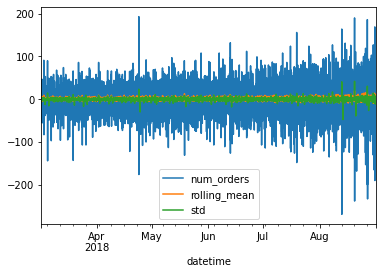

In [17]:
data.plot()

**Выводы:**

**Тренд:** увеличение среднего кол-ва заказов такси ближе к пятнице и в субботу. В воскресенье тухляк. В понедельник люди опаздывают, поэтому есть заказы. Во всех остальных днях недели снова тухляк. <br>
**Сезонность:** Самый "низкий" час для заказа такси с 5 до 7 утра. Ночью самый пик заказов, возможно едут после работы или тусы. 
**Стационарность:** Благодаря разности рядов мы сделали ряд более стационарным.

## Обучение

### Создадим признаки

In [18]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [19]:
data = data.drop(['rolling_mean', 'std'], axis=1)
data_new = data.copy()
make_features(data_new, 100, 24)
print(data_new.head())
print(data)

                     num_orders  month  day  dayofweek  hour  lag_1  lag_2  \

datetime                                                                     

2018-03-01 17:00:00         1.0      3    1          3    17    NaN    NaN   

2018-03-01 18:00:00        29.0      3    1          3    18    1.0    NaN   

2018-03-01 19:00:00       -28.0      3    1          3    19   29.0    1.0   

2018-03-01 20:00:00        16.0      3    1          3    20  -28.0   29.0   

2018-03-01 21:00:00         5.0      3    1          3    21   16.0  -28.0   



                     lag_3  lag_4  lag_5  ...  lag_92  lag_93  lag_94  lag_95  \

datetime                                  ...                                   

2018-03-01 17:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   

2018-03-01 18:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   

2018-03-01 19:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   

2018-03-01 20:00:00    1.0    NaN  

### Деление данных на тренировочные и тестовые

In [20]:
train, test = train_test_split(data_new, test_size=.1, shuffle=False)

train = train.dropna()
test = test.dropna()

train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)
train_target = train['num_orders']
test_target = test['num_orders']

Проверим еще раз, правильно ли разделили и проверим пропуски. Также убедимся в корректности деления.

In [21]:
print(train.shape[0])
print(test.shape[0])
print()
print(train.isna().sum())
print(test.isna().sum())
print()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

3859

440



num_orders      0

month           0

day             0

dayofweek       0

hour            0

               ..

lag_97          0

lag_98          0

lag_99          0

lag_100         0

rolling_mean    0

Length: 106, dtype: int64

num_orders      0

month           0

day             0

dayofweek       0

hour            0

               ..

lag_97          0

lag_98          0

lag_99          0

lag_100         0

rolling_mean    0

Length: 106, dtype: int64



2018-03-05 21:00:00 2018-08-13 15:00:00

2018-08-13 16:00:00 2018-08-31 23:00:00


Пропусков нет, разделили правильно. Теперь можно приступать к обучению модели.

### Линейная регрессия

In [22]:
model_linear = LinearRegression()
model_linear.fit(train_features, train_target)

predict_linear = model_linear.predict(test_features)

print('Mean Squared Error for Linear Regression', mean_squared_error(test_target, predict_linear, squared=False))

Mean Squared Error for Linear Regression 39.72626312855986


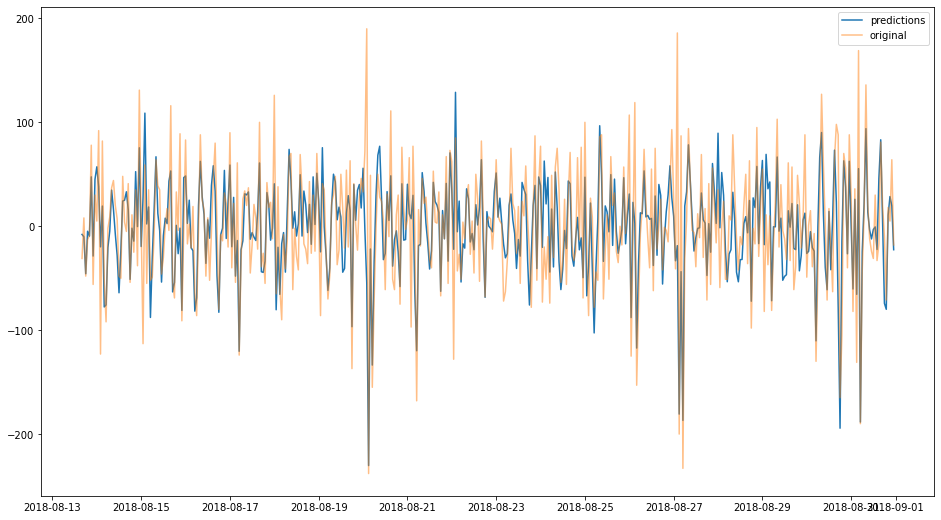

In [23]:
predict_data = pd.DataFrame(index=test_target.index, data=predict_linear)

plt.figure(figsize=(16,9))
plt.plot(predict_data, label='predictions')
plt.plot(test_target, label='original', alpha=.5)
plt.legend()

Впринципе на тренды модель реагирует.

### ARIMA 

Построим графики, чтобы определить лучшие параметры для модели

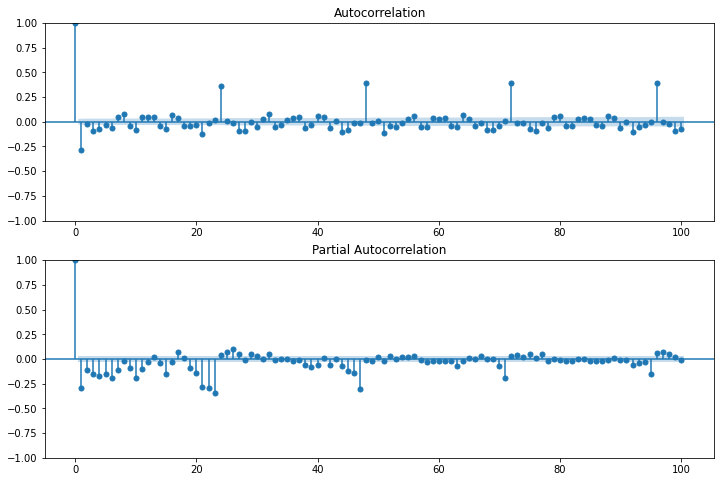

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
ax1 = plt.subplot(211)
fig = plot_acf(data.values.squeeze(), lags=100, ax=ax1)
ax2 = plt.subplot(212)
fig = plot_pacf(data, lags=100, ax=ax2)

На этих графиках можно увидеть, что число лагов (n) = 1, а размер окна скользящей средней (q) = 1 тоже.

Посмотрим через другой график автокорреляции.

Text(0.5, 1.0, 'Autocorrelation')

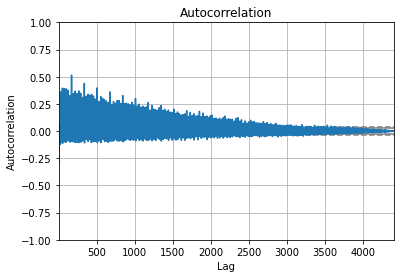

In [38]:
autocorrelation_plot(data)
plt.title('Autocorrelation')

Здесь уже кол-во лагов около 100.

In [39]:
arima_model = ARIMA(data[:'2018-08-13 15:00:00'], order=(5,1,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                


Dep. Variable:             num_orders   No. Observations:                 3959

Model:                 ARIMA(5, 7, 7)   Log Likelihood              -23967.314

Date:                Thu, 21 Jul 2022   AIC                          47960.629

Time:                        19:42:17   BIC                          48042.295

Sample:                    03-01-2018   HQIC                         47989.595

                         - 08-13-2018                                         

Covariance Type:                  opg                                         


                 coef    std err          z      P>|z|      [0.025      0.975]

------------------------------------------------------------------------------

ar.L1         -3.7836      0.015   -257.955      0.000      -3.812      -3.755

ar.L2         -6.6861      0.044   -151.822      0.000      -6.772      -6.600

ar.L3         -6.6838      0.059   -11

In [40]:
arima_predict = model.predict('2018-08-13 16:00:00', '2018-08-31 23:00:00', typ='levels')
print('RMSE:', mean_squared_error(data['2018-08-13 16:00:00':], arima_predict, squared=False))

RMSE: 7476860042.604866


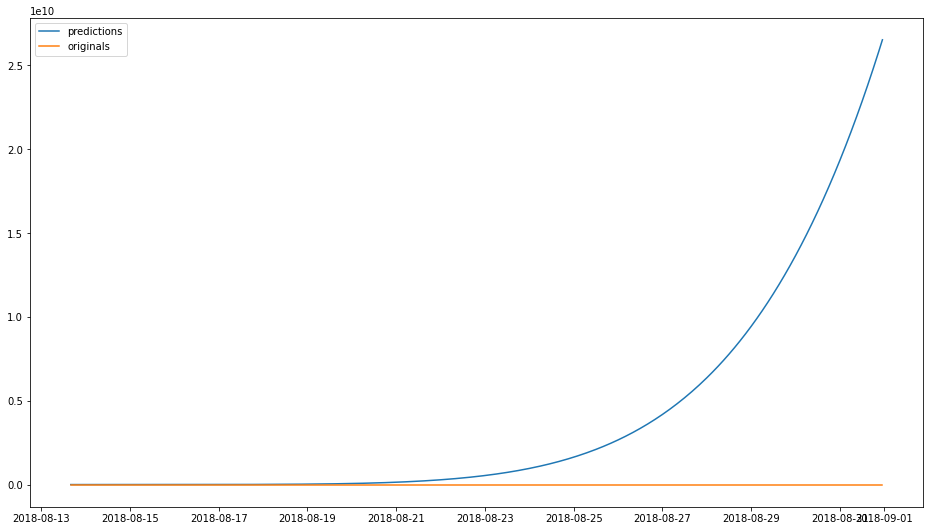

In [44]:
plt.figure(figsize=(16,9))
plt.plot(arima_predict, label='predictions')
plt.plot(data['2018-08-13 16:00:00':], label='originals')
plt.legend()

Здесь совсем грустные предсказания. Откидываем этот метод.

### CatBoost

In [29]:
train_pool = Pool(data=train_features,
                 label=train_target)

test_pool = Pool(data=test_features,
                label=test_target)

model_cb = CatBoostRegressor(loss_function='RMSE')

In [30]:
tscv = TimeSeriesSplit(n_splits=3)

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

model_cb.grid_search(grid, train_pool, cv=tscv)

0:	learn: 33.1783203	test: 45.7451142	best: 45.7451142 (0)	total: 51.3ms	remaining: 5.08s

1:	learn: 32.9837043	test: 45.5816916	best: 45.5816916 (1)	total: 55.4ms	remaining: 2.71s

2:	learn: 32.7679301	test: 45.3708064	best: 45.3708064 (2)	total: 58.8ms	remaining: 1.9s

3:	learn: 32.5229488	test: 45.1484123	best: 45.1484123 (3)	total: 62.5ms	remaining: 1.5s

4:	learn: 32.3335113	test: 44.9729802	best: 44.9729802 (4)	total: 66ms	remaining: 1.25s

5:	learn: 32.1474905	test: 44.8082632	best: 44.8082632 (5)	total: 69.6ms	remaining: 1.09s

6:	learn: 31.9681449	test: 44.6439073	best: 44.6439073 (6)	total: 73ms	remaining: 970ms

7:	learn: 31.7369151	test: 44.4169808	best: 44.4169808 (7)	total: 77ms	remaining: 886ms

8:	learn: 31.5562617	test: 44.2363905	best: 44.2363905 (8)	total: 80.5ms	remaining: 814ms

9:	learn: 31.3862617	test: 44.0875945	best: 44.0875945 (9)	total: 83.8ms	remaining: 755ms

10:	learn: 31.2266771	test: 43.9399181	best: 43.9399181 (10)	total: 87.3ms	remaining: 706ms

11:	l

{'params': {'depth': 6,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [31]:
print(model_cb.get_best_score())

{'learn': {'RMSE': 15.07478751837642}}


In [32]:
print('"params": "depth": 6, "iterations": 200, "learning_rate": 0.1, "l2_leaf_reg": 1}')

"params": "depth": 6, "iterations": 200, "learning_rate": 0.1, "l2_leaf_reg": 1}


## Тестирование

Т.к. линейную регрессию уже ранее протестировали, ARIMA не подходит, остается проверить только модель CatBoost'а.

In [33]:
result_fit_cb = %timeit -n1 -r1 -o sum(range(1000000))

model_cb2 = CatBoostRegressor(learning_rate=.1, depth=4, iterations=200, l2_leaf_reg=.5)
model_cb2.fit(train_pool)

23.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

0:	learn: 35.2297940	total: 8.94ms	remaining: 1.78s

1:	learn: 34.1778076	total: 17.6ms	remaining: 1.75s

2:	learn: 33.2891762	total: 26.4ms	remaining: 1.73s

3:	learn: 32.4914806	total: 34.8ms	remaining: 1.71s

4:	learn: 31.8726829	total: 42.9ms	remaining: 1.67s

5:	learn: 31.2939796	total: 57.8ms	remaining: 1.87s

6:	learn: 30.6745706	total: 69.6ms	remaining: 1.92s

7:	learn: 30.1967915	total: 78ms	remaining: 1.87s

8:	learn: 29.8056319	total: 86.4ms	remaining: 1.83s

9:	learn: 29.4491844	total: 94.7ms	remaining: 1.8s

10:	learn: 29.0024397	total: 105ms	remaining: 1.79s

11:	learn: 28.5882996	total: 113ms	remaining: 1.77s

12:	learn: 28.2703049	total: 121ms	remaining: 1.74s

13:	learn: 27.9706326	total: 130ms	remaining: 1.72s

14:	learn: 27.7153214	total: 138ms	remaining: 1.7s

15:	learn: 27.4913487	total: 152ms	remaining: 1.75s

16:	learn: 27.2438865	total: 162ms	remaining: 1.74s

17:	learn: 27.0332313	total: 170ms	re

In [34]:
result_predict_cb = %timeit -n1 -r1 -o sum(range(1000000))

predictions_cb = model_cb2.predict(test_pool)

print('Catboost RMSE', mean_squared_error(test_target, predictions_cb, squared=False))

14.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Catboost RMSE 42.52546279143557


In [35]:
predictions_cb = pd.DataFrame(index=test_target.index, data=predictions_cb)

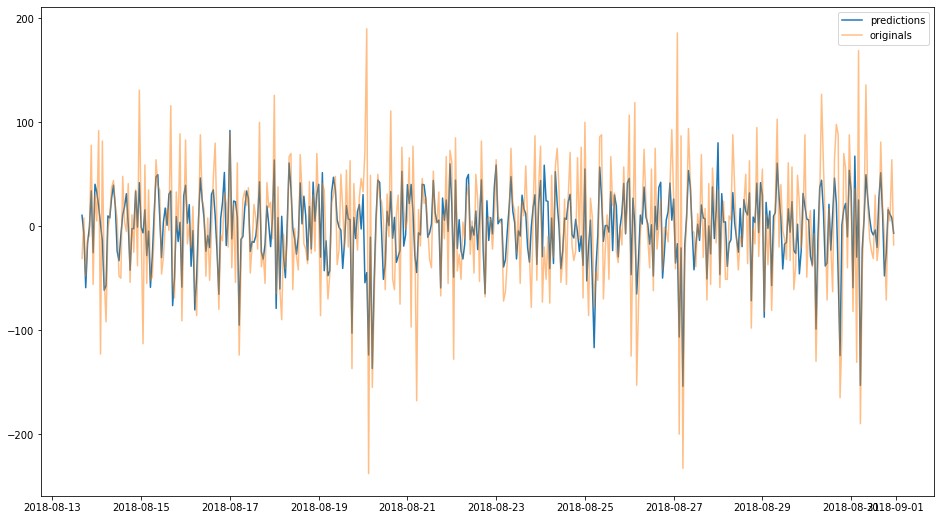

In [36]:
plt.figure(figsize=(16,9))
plt.plot(predictions_cb, label='predictions')
plt.plot(test_target, label='originals', alpha=.5)
plt.legend()

### Вывод

* Подготовили данные и поработали с индексами
* Создали дополнительные признаки для лучшей обучаемости модели
* Разделили на тренировочную и тестовую выборки
* Обучили несколько моделей:
    * Линейную регрессию
    * ARIMA
    * CatBoost
* На основании обученных моделей сделали вывод, что лучшей является Линейная Регрессия.

Конечно, объективней надо было проводить кросс-валидацию и на линейной регрессии, но уже не сейчас...

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48